In [66]:
## Standard libraries
import os
import math
import numpy as np
import time
## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib_inline
from PIL.features import features, check
from nest_asyncio import apply

matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
from flax import linen as nn
## Progress bar
from tqdm.auto import tqdm

In [67]:
import jax
import jax.numpy as jnp
print("using jax", jax.__version__)
print("Current Device", jax.devices())

using jax 0.4.35
Current Device [CudaDevice(id=0)]


In [68]:
class SimpleClassifier(nn.Module):
    num_hidden : int
    num_outputs : int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x
    
model = SimpleClassifier(num_hidden=8, num_outputs=1)
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [69]:
rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(42), 3)
inp = jax.random.normal(inp_rng, shape=(8, 2))
params = model.init(init_rng, inp)
print(params, inp)
model.apply(params, inp)

{'params': {'Dense_0': {'kernel': Array([[-0.87348896,  0.03292416,  0.4509564 ,  0.9860289 ,  0.9650169 ,
        -0.5035698 , -0.5674411 , -0.32092765],
       [ 0.6106077 , -0.80351436, -0.84972376, -1.0364469 ,  0.11642705,
        -0.37274957, -0.06301995,  0.23880553]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'Dense_1': {'kernel': Array([[-0.0897337 ],
       [-0.155723  ],
       [ 0.1259761 ],
       [-0.02248076],
       [ 0.4882281 ],
       [ 0.19107282],
       [-0.32372734],
       [-0.04857435]], dtype=float32), 'bias': Array([0.], dtype=float32)}}} [[ 1.4737936  -0.761498  ]
 [ 0.3014277  -1.6144454 ]
 [ 0.50212544  0.6380023 ]
 [-0.66141325  0.3094598 ]
 [ 1.1601422  -0.6781818 ]
 [-1.4953445   1.1496265 ]
 [-0.16919976 -0.14370923]
 [-2.5454128  -0.96469074]]


Array([[ 0.6650058 ],
       [ 0.2090462 ],
       [ 0.30390528],
       [-0.4101299 ],
       [ 0.59759915],
       [-0.6680308 ],
       [-0.11172037],
       [-0.8201499 ]], dtype=float32)

In [70]:
import torch.utils.data as data
class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), np.int32(1))


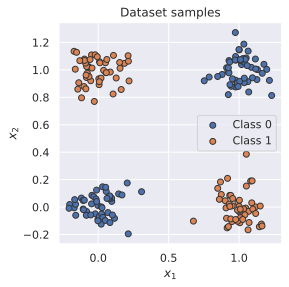

In [71]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
visualize_samples(dataset.data, dataset.label)
plt.show()

In [72]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 0.91104853 -0.08158103]
 [ 1.1158111   1.0791663 ]
 [ 0.9243649  -0.14222537]
 [-0.03152692  0.07589692]
 [ 0.97765374  1.0714    ]
 [ 0.10062928 -0.05768919]
 [ 1.0473237  -0.00728289]
 [-0.0985726   0.05040465]]
Data labels (8,) 
 [1 0 1 0 0 0 1 0]


In [73]:
import optax
optimizer = optax.adamw(learning_rate=0.1)
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn = model.apply,
                                            params = params,
                                            tx = optimizer)

def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.67472947, dtype=float32), Array(0.625, dtype=float32))

In [74]:
@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(calculate_loss_acc,
                                 argnums=1,
                                 has_aux=True)
    (loss, acc), grads = grad_fn(state, state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss, acc

@jax.jit
def eval_step(state, batch):
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

train_dataset = XORDataset(size=2048, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

def train_model(state, data_loader, num_epochs=100):
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
    return state
train_model_state = train_model(model_state, train_data_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

In [75]:
from flax.training import checkpoints
checkpoints.save_checkpoint(ckpt_dir="/home/xys/VSD-with-jax/my_checkpoints/",
                            target=train_model_state,
                            step=100,
                            prefix="my_model",
                            overwrite=True)


'/home/xys/VSD-with-jax/my_checkpoints/my_model100'

In [76]:
loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir='home/xys/VSD~with~jax/my_checkpoints/',   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='my_model'  # Checkpoint file name prefix
                                            )

In [77]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)

In [78]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [80]:
eval_model(train_model_state, test_data_loader)

Accuracy of the model: 100.00%


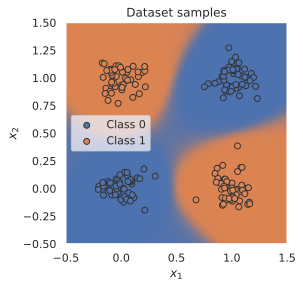

In [81]:
trained_model = model.bind(train_model_state.params)
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()

In [ ]:
## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial6_jax"

print("Device:", jax.devices()[0])

# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

class MultiheadAttention(nn.Module):
    embed_dim : int  # Output dimension
    num_heads : int  # Number of parallel heads (h)

    def setup(self):
        # Stack all weight matrices 1...h and W^Q, W^K, W^V together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Dense(3*self.embed_dim,
                                 kernel_init=nn.initializers.xavier_uniform(),  # Weights with Xavier uniform init
                                 bias_init=nn.initializers.zeros  # Bias init with zeros
                                )
        self.o_proj = nn.Dense(self.embed_dim,
                               kernel_init=nn.initializers.xavier_uniform(),
                               bias_init=nn.initializers.zeros)

    def __call__(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.shape
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1)
        qkv = qkv.transpose(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = jnp.array_split(qkv, 3, axis=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.transpose(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        return o, attention